### Exploring Automated SSH Cyber Attacks

We'll take a look at some cyber security data gathered by a SSH honeypot. SSH is a protocol for connecting to remote servers on a network, which in this case is the internet. 

Dataset can be found here: https://www.kaggle.com/lako65/ssh-brute-force-ipuserpassword

Lets go ahead and take a look at our dataset

In [1]:
import pandas as pd

# We'll set a few global configurations so we can see more rows/columns when we output tables
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)


attacks_df = pd.read_json('brute_force_data.json', orient='records')
attacks_df.head()

,foreign_ip,passwords,timestamp,username
0,109.87.224.151,"[      , albert, 123456]",2018-11-05 08:31:18,albert
1,122.226.181.166,"[digi, daddy913, covergirl]",2018-11-05 22:16:56,root
2,42.7.27.166,"[qwerty11, qwerty12, qweqweqwe, qwer`123, qwer...",2018-11-05 07:18:16,root
3,125.65.42.181,"[123456, root, password]",2018-11-03 19:30:58,root
4,61.184.247.12,"[lomtjjz, lolita, jake1996]",2018-11-05 08:53:41,root


In [2]:
attacks_df.count()

foreign_ip    14795
passwords     14795
timestamp     14795
username      14795
dtype: int64

Interesting! So we have the attack location via IP address, the time it occurred and the username/password combinations used for the attack. This dataset can give us some insights on what attackers use often (and what you probably should avoid!)

Pay attention to the values in the passwords field. You'll notice that they are in a list format. Data formatted like this isn't intuitive for analytics. Think of it this way: each list is like a table and you end up with a table within a table. Data formatted like this can confuse some querying functions. Lets fix this first.

### Exercise: 
In the starting code below, try to flatten the passwords column in the dataframe. Read the comments below or ask questions if you're not sure what to do

In [3]:
import copy

attack_rows = attacks_df.to_dict(orient='records')

attacks_flattened_df = list()
for row in attack_rows:
  
  # row has a dictionary that looks like this {'foreign_ip': 'x.x.x.x', 'passwords': ['password1', 'pass2'], 'timestamp': datetime.object, 'username': 'john'}
  if isinstance(row['passwords'], list):
    # Try to flatten the rows so that it appears like this instead:
    # {'foreign_ip': 'x.x.x.x', 'passwords': 'password1', 'timestamp': datetime.object, 'username': 'john'}
    # {'foreign_ip': 'x.x.x.x', 'passwords': 'pass2', 'timestamp': datetime.object, 'username': 'john'}
    attacks_flattened_df.append(row)
  else:
    attacks_flattened_df.append(row)


In [4]:
import copy

attack_rows = attacks_df.to_dict(orient='records')

attacks_flattened_df = list()
for row in attack_rows:
  
  # row has a dictionary that looks like this {'foreign_ip': 'x.x.x.x', 'passwords': ['password1', 'pass2'], 'timestamp': datetime.object, 'username': 'john'}
  if isinstance(row['passwords'], list):
    for pw in row['passwords']:
      
      # We're gonna copy each row and modify the copy so we don't screw up the original
      r = copy.copy(row)
      r['password'] = pw
      attacks_flattened_df.append(r)
  else:
    attacks_flattened_df.append(row)


In [5]:
# we dont need the passwords list anymore. Lets remove it
attacks_flattened_df = pd.DataFrame(attacks_flattened_df)
attacks_flattened_df = attacks_flattened_df.drop(columns="passwords")
attacks_flattened_df.head()

,foreign_ip,password,timestamp,username
0,109.87.224.151,      ,2018-11-05 08:31:18,albert
1,109.87.224.151,albert,2018-11-05 08:31:18,albert
2,109.87.224.151,123456,2018-11-05 08:31:18,albert
3,122.226.181.166,digi,2018-11-05 22:16:56,root
4,122.226.181.166,daddy913,2018-11-05 22:16:56,root


Lets do some analytics. Looking at our data, we can see that the variables of interest (basically all the variables, except maybe timestamps), are categorical types. Therefore, it would not necessarily help to get the mean, std, percentile, etc for our dataset.

We can still try it and see for the fun of it.

In [6]:
attacks_flattened_df.describe()

,foreign_ip,password,timestamp,username
count,53756,53756,53756,53756
unique,303,22736,14251,441
top,116.31.116.42,123456,2018-11-06 23:07:44,root
freq,8329,469,12,52124
first,NaN,NaN,2018-11-03 19:30:58,NaN
last,NaN,NaN,2018-11-07 14:17:33,NaN


In [7]:
# How many unique passwords are in the dataset? Assign your answer to the unique_count variable below then run the cell
unique_count = 0 # Replace with your answer
print("Correct!" if unique_count == len(attacks_flattened_df['password'].unique()) else "Try again")


Try again


### Popular passwords used

To get an idea of what passwords were common, we can use a popular data querying function called *Groupby*. *Groupby* aggregates records with identical elements, counting their frequency. here we'll aggregate records with the same password values. We'll then take this count and sort it in descending order.

In [8]:
attacks_flattened_df.groupby(['password']).count().reset_index().sort_values('foreign_ip', ascending=False)

,password,foreign_ip,timestamp,username
1064,123456,469,469,469
15818,password,447,447,447
0,      ,423,423,423
17602,root,416,416,416
20568,ubuntu,410,410,410
17636,root123,405,405,405
7780,centos6svm,387,387,387
15861,passwrod,353,353,353
5395,admin,108,108,108
16954,qwerty,68,68,68


Cool! Now we know the commonly used passwords for attacks. Should definitely avoid those. Thats not enough though. There are still over 22k unique passwords, and our table doesn't necessarily help. We don't want have to look at all 22k passwords to know which ones we shouldn't use. Wouldn't it be great if you can know how secure a password might be?

We can probably do that.

### Exploring Passwords


Since there are over 22k unique passwords in this dataset, we can have an idea of what they look like by examining their features. Features can be any distinguishing attribute, for example, password length. Below we'll extract a few features and do some statistical analysis on them.  

In [9]:
# We'll only be looking at passwords from now on, so we'll create a new dataframe with the passwords column only
passwords_df = attacks_flattened_df['password']

In [10]:
# The number of character classes used (uppercase, lowercase, numbers, special 
# characters) is also a feature, along with the character pool. The character pool is 
# the list of possible unique characters in the password, depending on the character classes used. 

# e.g. if an uppercase character is present, a brute force algorithm would need to 
# check every possible uppercase character; therefore, all uppercase characters are 
# added to the character pool

def count_char_classes(pw):
    character_classes = list()
    character_classes.append(any([c.islower() for c in pw]))
    character_classes.append(any([c.isupper() for c in pw]))
    character_classes.append(any([c.isdigit() for c in pw]))
    character_classes.append(any([not c.isalpha() and not c.isdigit() for c in pw]))
    
    return sum(1 if x else 0 for x in character_classes)

In [11]:
# the presence of a word can affect the guessability of a password. It might help if we test for that. 
# Be aware that this function will take a while for the sake of precision

from nltk.corpus import words
dictionary_index = dict.fromkeys(words.words(), True)

def has_word(pw):
  # returns true if pw is or contains a dictionary word 
  return True if dictionary_index.get(pw, None) else False

In [12]:
# We can also calculate entropy bits, which basically is how unpredictable it is. 
# To give you an idea of what entropy bits mean, heres an excerpt From Wikipedia: 
# "...a password with an entropy of 42 bits would require 2^(42) (4,398,046,511,104) 
#  attempts to exhaust all possibilities during a brute force search"
 
# Read more about it here: (https://en.wikipedia.org/wiki/Password_strength#Entropy_as_a_measure_of_password_strength, https://www.pleacher.com/mp/mlessons/algebra/entropy.html)
from math import log

special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '.', ',', '?', '/', '>', '<', '[', ']', '{', '}', '|', '\\', ';', ':','+', '=', '-', '_', ' ']
character_classes = [
    'abcdefghijklmnopqrstuvwxyz',
    'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
    '0123456789',
    special_chars
]

def entropy_bits(password):
    if len(password) <= 1:
        return 0

    uniq_char_pool = []
    uniq_test = (any(1 for c in password if c.islower()), 
                any(1 for c in password if c.isupper()), 
                any(1 for c in password if c.isdigit()), 
                any(1 for c in password if c in special_chars))

    for i in range(4):
        if uniq_test[i]:
            uniq_char_pool += list(character_classes[i])

    if len(uniq_char_pool)<=0:
        return 0

    return log(len(uniq_char_pool)**len(password), 2)

In [13]:
# Lets package these features in a function for easier future use
def password_features(pass_df):
    feats_df = pd.DataFrame(pass_df)
    
    # Password length is a feature that affects how easy it is to crack with brute force
    # methods. Lets add that to our table.
    feats_df['password_length'] = feats_df['password'].apply(lambda x: len(x))
 
    # the number of character classes is also a feature. Each character class represents 
    # the pool of characters a hacker would have to test for each character in the string 
    feats_df['character_classes'] = feats_df['password'].apply(count_char_classes) 
    
    # the presence of words in a password is also a feature. Passwords with words in them are easier to guess
    feats_df['dictionary_presence'] = feats_df['password'].apply(
      lambda x: 1 if has_word(x) else 0)
    
    # Now we'll count how many characters from each character class is present in the password
    feats_df['letters'] = feats_df['password'].apply(lambda x: sum(1 for c in x if c.isalpha()))
    feats_df['numbers'] = feats_df['password'].apply(lambda x: sum(1 for c in x if c.isdigit()))
    feats_df['special_chars'] = feats_df['password'].apply(lambda x: sum(1 for c in x if c in special_chars))
    feats_df['uppercase_characters'] = feats_df['password'].apply(lambda x: sum(1 for c in x if c.isupper()))
    feats_df['lowercase_characters'] = feats_df['password'].apply(lambda x: sum(1 for c in x if c.islower()))
    
    
    # Finally, lets calculate entropy
    feats_df['entropy'] = feats_df['password'].apply(entropy_bits)
    
    return feats_df

In [14]:
passwords_feats_df = password_features(passwords_df)

Now let's have a look at some basic statistics of the features

In [15]:
passwords_feats_df.describe()

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy
count,53756.000000,53756.000000,53756.000000,53756.000000,53756.000000,53756.000000,53756.000000,53756.000000,53756.000000
mean,7.377260,1.463018,0.157936,5.196666,1.847757,0.267170,0.128544,5.068123,35.780622
std,2.611556,0.688822,0.364684,3.070137,2.591020,1.019163,0.781468,3.050600,16.247725
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,26.575425
50%,7.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,6.000000,32.903078
75%,8.000000,2.000000,0.000000,7.000000,3.000000,0.000000,0.000000,7.000000,42.303957
max,60.000000,4.000000,1.000000,46.000000,26.000000,23.000000,33.000000,45.000000,390.467678


If you look at the entropy values, you'll see that the average entropy is 36 bits (which requires about 2^(36) or 68719476736 attempts to exhaust all possibilities). Passwords in the 75 percentile (most of them) have an entropy value of around 42, which requires around 2^(42) (4,398,046,511,104) attempts. The password with the largest length (60 characters) has an entropy of 390, which is pretty would take a massive number of attempts (1.260864e+117 attempts). 

Lets see what that password looks like:

In [16]:
# Get the password with the longest length from passwords_feats_df
passwords_feats_df[passwords_feats_df['password_length'] == passwords_feats_df['password_length'].max()]['password'].values[0]

'Rhosts authentication refused for %.100s: bad ownership or m'

Doesn't look like a password at all! Its understandable to find junk like this in our dataset, since it contains brute force attempts. 

Lets see how corelated the features are

In [17]:
# shows how corelated the features are to each other
passwords_feats_df.corr()

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy
password_length,1.000000,0.427933,-0.218844,0.508469,0.284846,0.291588,0.237409,0.450909,0.922971
character_classes,0.427933,1.000000,-0.285041,0.020346,0.285382,0.350268,0.321833,-0.061967,0.626202
dictionary_presence,-0.218844,-0.285041,1.000000,0.121429,-0.308849,-0.113481,-0.065885,0.139085,-0.193039
letters,0.508469,0.020346,0.121429,1.000000,-0.592813,-0.095379,0.152191,0.967418,0.566921
numbers,0.284846,0.285382,-0.308849,-0.592813,1.000000,0.018165,-0.006450,-0.594957,0.161605
special_chars,0.291588,0.350268,-0.113481,-0.095379,0.018165,1.000000,0.175785,-0.141020,0.382924
uppercase_characters,0.237409,0.321833,-0.065885,0.152191,-0.006450,0.175785,1.000000,-0.103003,0.311144
lowercase_characters,0.450909,-0.061967,0.139085,0.967418,-0.594957,-0.141020,-0.103003,1.000000,0.490847
entropy,0.922971,0.626202,-0.193039,0.566921,0.161605,0.382924,0.311144,0.490847,1.000000


Notice that almost every feature (dictionary_presence isn't) is positively corelated with entropy (increases when entropy increases). The character class has the greatest influence on entropy (0.92) followed by the password length.

## A More Practical Dataset

Remember, our dataset has passwords from brute force attempts to gain access to a publically accessible SSH port. The passwords in our dataset don't exactly reflect passwords people use, more so what hackers assume they would use for a server. Therefore, the dataset is a bit skewed towards popular passwords within that domain; that explains why you see passwords like 'password', 'admin', 'root', 'toor' and '123456' which are common default passwords. Attackers are hoping that these passwords were not updated so they can take advantage of that vulnerbility.

Lets detour from here and take a look at actual passwords. Online, you can find password datasets from various data breaches. We'll use [this one](https://raw.githubusercontent.com/berzerk0/Probable-Wordlists/master/Real-Passwords/Top304Thousand-probable-v2.txt) which should have passwords that were actually used.

### Exercise:
Load the dataset Top304Thousand_passwords.txt into a dataframe called real_passwords with column name 'password'. 
When you're done, print the first 5 rows of the dataframe

In [18]:
# assuming the file is in the same directory as the junyper notebook

# Exercise! load the dataset Top304Thousand_passwords.txt into a dataframe called real_passwords with column name 'password'
# Print the dataframe

In [19]:
# assuming the file is in the same directory as the junyper notebook
real_passwords = dict()

with open("Top304Thousand_passwords.txt") as f:
    real_passwords['password'] = [line.rstrip() for line in f]

real_passwords = pd.DataFrame(real_passwords)
real_passwords.head()

,password
0,123456
1,password
2,123456789
3,12345678
4,12345


Now lets calculate the features for the new passwords

In [20]:
real_passwords = password_features(real_passwords)
real_passwords.head()

,password,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy
0,123456,6,1,0,0,6,0,0,0,19.931569
1,password,8,1,1,8,0,0,0,8,37.603518
2,123456789,9,1,0,0,9,0,0,0,29.897353
3,12345678,8,1,0,0,8,0,0,0,26.575425
4,12345,5,1,0,0,5,0,0,0,16.609640


And now let's look at some statistics about our realistic passwords dataset.

In [21]:
real_passwords.describe()

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy
count,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000
mean,8.250645,1.114765,0.425024,7.547671,0.701674,0.001234,0.023767,7.523905,38.570519
std,2.260641,0.324622,0.494348,3.130493,1.917311,0.071525,0.310712,3.149089,11.277861
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,6.000000,31.019550
50%,8.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,8.000000,37.603518
75%,9.000000,1.000000,1.000000,9.000000,0.000000,0.000000,0.000000,9.000000,46.529325
max,26.000000,4.000000,1.000000,26.000000,20.000000,10.000000,11.000000,26.000000,122.211433


In [22]:
real_passwords.corr()

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy
password_length,1.000000,-0.056418,0.381857,0.793380,-0.116234,-0.002361,-0.031593,0.791812,0.964276
character_classes,-0.056418,1.000000,-0.281854,-0.170244,0.210231,0.030043,0.116451,-0.180728,0.087055
dictionary_presence,0.381857,-0.281854,1.000000,0.468820,-0.314648,-0.014834,-0.042347,0.470230,0.380057
letters,0.793380,-0.170244,0.468820,1.000000,-0.696386,-0.024418,-0.010401,0.995121,0.876241
numbers,-0.116234,0.210231,-0.314648,-0.696386,1.000000,-0.000243,-0.020453,-0.690256,-0.293977
special_chars,-0.002361,0.030043,-0.014834,-0.024418,-0.000243,1.000000,0.005048,-0.024772,0.006440
uppercase_characters,-0.031593,0.116451,-0.042347,-0.010401,-0.020453,0.005048,1.000000,-0.109007,-0.001413
lowercase_characters,0.791812,-0.180728,0.470230,0.995121,-0.690256,-0.024772,-0.109007,1.000000,0.871206
entropy,0.964276,0.087055,0.380057,0.876241,-0.293977,0.006440,-0.001413,0.871206,1.000000


With the real world passwords, numbers and uppercase characters are negatively correlated with entropy. Looking at the stats, this seems to be due to how infrequent uppercase characters and numbers appear in the passwords. Notice that the average entropy is still around 35-39 (roughly 274,877,906,944 attempts).

### Exercise!

Draw a plot of your choice using our dataset. Feel free to tweak the dataset and visualize your findings, but ensure your tweaks are not persistent (assign to a new variable or use `inplace=False`)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib
fig, ax = plt.subplots(figsize=(10,4))
sns.set_context("notebook")


corr = real_passwords.drop('password', axis=1, inplace=False).corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0.0,
            square=True, linewidths=.1,
            cbar_kws={"shrink": .8})

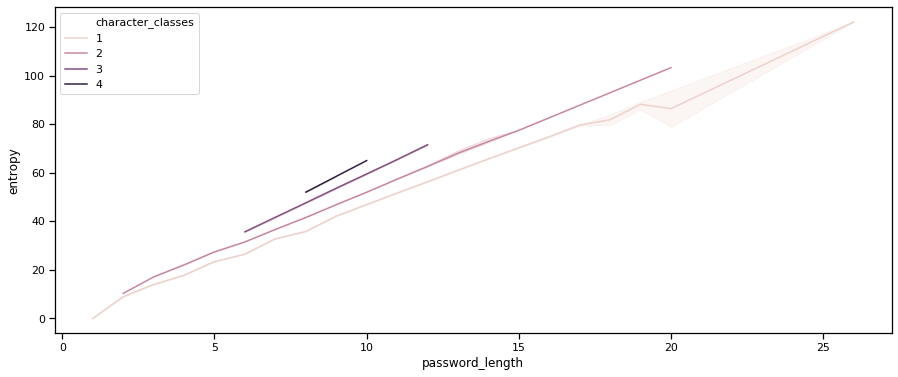

In [24]:
#%matplotlib
fig, ax = plt.subplots(figsize=(15,6))
sns.set_context("notebook")

ax = sns.lineplot(x="password_length", y="entropy", hue="character_classes", data=real_passwords)

## Machine Learning

Okay, lets make things a little interesting now. We have our formula for calculating entropy. which gives us an idea of the effort required to crack our passwords (using brute force method), but what if a we had a model that could predict this for us? Lets try to build this model!

As we progress, bear in mind our features and their correlation with entropy.

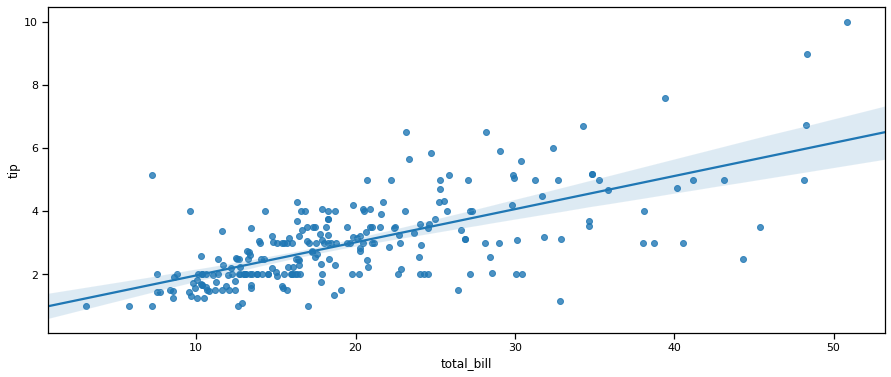

In [25]:
# Just for insights, this is a very simplified visualization of what machine learning does
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib
fig, ax = plt.subplots(figsize=(15,6))
sns.set_context("notebook")

sns.set(color_codes=True)
tips = sns.load_dataset("tips")
ax = sns.regplot(x="total_bill", y="tip", data=tips)

In [26]:
# first, lets extract the features from the dataset
feats = real_passwords[['password_length', 'character_classes',
       'dictionary_presence', 'letters', 'numbers', 'special_chars',
       'uppercase_characters', 'lowercase_characters']]

target = real_passwords['entropy']

# Then lets start training the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression()

# We'll need to split our training data from our test data
x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size=0.33,
                                                    random_state=42)

# Now we'll train the model to fit our data
model.fit(x_train, y_train)

# And lets see how well our model's predictions are
model.score(x_test, y_test)

0.9969248263774659

That looks like a pretty good score! (99% predictible) How about we test the model and see.

In [27]:
predictions = pd.DataFrame(y_test)
predictions['predicted'] = model.predict(x_test)
print(predictions.head())
print('\n')
print(predictions.describe())

          entropy  predicted
139546  42.303957  42.296280
269509  28.202638  28.091202
236846  37.603518  37.552140
102464  28.202638  28.091202
54567   47.004397  47.024796


             entropy      predicted
count  100278.000000  100278.000000
mean       38.595938      38.596321
std        11.276827      11.250285
min         0.000000       3.130157
25%        31.019550      30.665421
50%        37.603518      37.563858
75%        47.004397      47.013077
max       103.398500      94.329483


Thats amazing results from the model! The predictions turn out to be very close to the actual entropy values.

 Try it yourself! 
 Come up with a secure password and see how well it ranks. BE SURE NOT TO USE ANY PASSWORDS THAT YOU CURRENTLY USE FOR ANYTHING. THE COPS WILL COME GET YOU IF YOU DO. [DONT DO IT.](http://i.imgur.com/ZymDlls.gifv)

In [28]:
# Replace "change me" and "update me" with your own secure password ideas and run the cell.
my_test_passwords = pd.DataFrame([['change me'], ['update me']], columns=['password'])


my_test_passwords = password_features(my_test_passwords)
my_test_pass_feats = my_test_passwords[['password_length', 'character_classes',
       'dictionary_presence', 'letters', 'numbers', 'special_chars',
       'uppercase_characters', 'lowercase_characters']]
my_test_passwords['predicted entropy'] = model.predict(my_test_pass_feats)
my_test_passwords

,password,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy,predicted entropy
0,change me,9,2,0,8,0,1,0,8,52.032237,49.288468
1,update me,9,2,0,8,0,1,0,8,52.032237,49.288468


## Lets Get Real! 
*puts shades on*

Ooookay. Entropy numbers are nice, but they're meaningless if the password you use was similar or completely identitical to a leaked password. We can check each password against a rainbow table or cracking software, but that will require considerable effort...that some smart guys were kind enough to do for us and made it public :). 

So lets use their 'research-backed' password checker to add a few additional features to our dataset and model. We'll be using a library originally developed by Dropbox for determining password security. Its called zxcvbn (the 6 sequence of letters on the lowest row of the keyboard from left to right. Resembles one of the popular password patterns). You can find more info about it [here](https://github.com/dropbox/zxcvbn). The paper can be found [here](https://www.usenix.org/conference/usenixsecurity16/technical-sessions/presentation/wheeler) if you care about that stuff

**cough** nerd **cough**

In [29]:
# lets see what is available to us from the library
from zxcvbn import zxcvbn
zxcvbn('change me')

{'password': 'change me',
 'guesses': Decimal('582000'),
 'guesses_log10': 5.764922984649887,
 'sequence': [{'pattern': 'dictionary',
   'i': 0,
   'j': 5,
   'token': 'change',
   'matched_word': 'change',
   'rank': 286,
   'dictionary_name': 'us_tv_and_film',
   'reversed': False,
   'l33t': False,
   'base_guesses': 286,
   'uppercase_variations': 1,
   'l33t_variations': 1,
   'guesses': 286,
   'guesses_log10': 2.4563660331290427},
  {'pattern': 'bruteforce',
   'token': ' me',
   'i': 6,
   'j': 8,
   'guesses': 1000,
   'guesses_log10': 2.9999999999999996}],
 'calc_time': datetime.timedelta(0, 0, 2324),
 'crack_times_seconds': {'online_throttling_100_per_hour': Decimal('20952000.00000000116306964060'),
  'online_no_throttling_10_per_second': Decimal('58200'),
  'offline_slow_hashing_1e4_per_second': Decimal('58.2'),
  'offline_fast_hashing_1e10_per_second': Decimal('0.0000582')},
 'crack_times_display': {'online_throttling_100_per_hour': '8 months',
  'online_no_throttling_10_p

OOOOOO thats a lot of interesting stuff that we're going to ignore for now! You can take your time and look through the results above later. For now, we'll force on two metrics; the number of guesses and the offline show hashing time. 

With the additional info, we'll train a new model that would predict how long a passoword will take to crack.

In [30]:
# lets add the new features to our dataset 
# this is really intensive, so we'll need some help from our CPU core buddies
# copied from https://stackoverflow.com/a/53135031 because I'm too tired for this
from multiprocessing import  Pool
from functools import partial
import numpy as np

def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)
  
  

def apply_guess(df):
  return zxcvbn(df['password'])['guesses']

def apply_crack(df):
  return zxcvbn(df['password'])['crack_times_seconds']['offline_slow_hashing_1e4_per_second']

In [31]:
# CAUTION: This code will take really long and might make your computer really hot/drain battery
# real_passwords['guesses'] = parallelize_on_rows(real_passwords, apply_guess)
# real_passwords['crack_time'] = parallelize_on_rows(real_passwords, apply_crack)

# Below, I save the results to a file so we don't need to spend minutes crunching the numbers again *bleh*
#real_passwords.to_csv('real_passwords_with_guesses.csv', index=False, encoding='utf-8')

# I've provided the above changes in a file to save time. Please use that file. If you wish to crunch the numbers manually, may your PC rest in peace.
real_passwords = pd.read_csv('real_passwords_with_guesses.csv')

In [32]:
real_passwords.head()

,password,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy,guesses,crack_time
0,123456,6,1,0,0,6,0,0,0,19.931569,2.0,0.0002
1,password,8,1,1,8,0,0,0,8,37.603518,3.0,0.0003
2,123456789,9,1,0,0,9,0,0,0,29.897353,6.0,0.0006
3,12345678,8,1,0,0,8,0,0,0,26.575425,4.0,0.0004
4,12345,5,1,0,0,5,0,0,0,16.609640,7.0,0.0007


In [33]:
# And very quickly, look at the statistics!
# IF you crunched the numbers manually, you need to uncomment the two lines below and run them
# real_passwords['guesses'] = pd.to_numeric(real_passwords['guesses'])
# real_passwords['crack_time'] = pd.to_numeric(real_passwords['crack_time'])

real_passwords.describe()

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy,guesses,crack_time
count,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,303872.000000,3.038720e+05,3.038720e+05
mean,8.250645,1.114765,0.425024,7.547671,0.701674,0.001234,0.023767,7.523905,38.570519,2.636379e+13,2.636379e+09
std,2.260641,0.324622,0.494348,3.130493,1.917311,0.071525,0.310712,3.149089,11.277861,8.483755e+15,8.483755e+11
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,2.000000e-04
25%,7.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,6.000000,31.019550,1.215500e+04,1.215500e+00
50%,8.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,8.000000,37.603518,1.000010e+05,1.000010e+01
75%,9.000000,1.000000,1.000000,9.000000,0.000000,0.000000,0.000000,9.000000,46.529325,1.132653e+07,1.132653e+03
max,26.000000,4.000000,1.000000,26.000000,20.000000,10.000000,11.000000,26.000000,122.211433,4.200000e+18,4.200000e+14


In [34]:
corr = real_passwords.drop('password', axis=1, inplace=False).corr()
corr

,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy,guesses,crack_time
password_length,1.000000,-0.056418,0.381857,0.793380,-0.116234,-0.002361,-0.031593,0.791812,0.964276,0.014303,0.014303
character_classes,-0.056418,1.000000,-0.281854,-0.170244,0.210231,0.030043,0.116451,-0.180728,0.087055,-0.001099,-0.001099
dictionary_presence,0.381857,-0.281854,1.000000,0.468820,-0.314648,-0.014834,-0.042347,0.470230,0.380057,0.003607,0.003607
letters,0.793380,-0.170244,0.468820,1.000000,-0.696386,-0.024418,-0.010401,0.995121,0.876241,0.011026,0.011026
numbers,-0.116234,0.210231,-0.314648,-0.696386,1.000000,-0.000243,-0.020453,-0.690256,-0.293977,-0.001137,-0.001137
special_chars,-0.002361,0.030043,-0.014834,-0.024418,-0.000243,1.000000,0.005048,-0.024772,0.006440,-0.000054,-0.000054
uppercase_characters,-0.031593,0.116451,-0.042347,-0.010401,-0.020453,0.005048,1.000000,-0.109007,-0.001413,-0.000238,-0.000238
lowercase_characters,0.791812,-0.180728,0.470230,0.995121,-0.690256,-0.024772,-0.109007,1.000000,0.871206,0.010985,0.010985
entropy,0.964276,0.087055,0.380057,0.876241,-0.293977,0.006440,-0.001413,0.871206,1.000000,0.013534,0.013534
guesses,0.014303,-0.001099,0.003607,0.011026,-0.001137,-0.000054,-0.000238,0.010985,0.013534,1.000000,1.000000


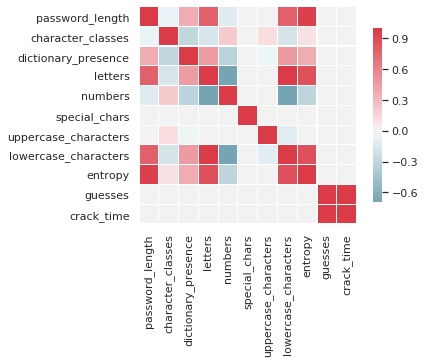

In [35]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0.0,
            square=True, linewidths=.1,
            cbar_kws={"shrink": .8})

Looks like things are gonna be weird from that heatmap. Lets see what happens.

In [36]:
# and lets train a new model

feats2 = real_passwords[['password_length', 'character_classes',
       'dictionary_presence', 'letters', 'numbers', 'special_chars',
       'uppercase_characters', 'lowercase_characters', 'entropy', 'guesses']]

target2 = real_passwords['crack_time']

# Then lets start training the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model2 = LinearRegression()

# We'll need to split our training data from our test data
x_train2, x_test2, y_train2, y_test2 = train_test_split(feats2, target2, test_size=0.33,
                                                    random_state=42)

# Now we'll train the model to fit our data
model2.fit(x_train2, y_train2)

# And lets see how well our model's predictions are
model2.score(x_test2, y_test2)

1.0

### HOLY MOLY BREDDA

What is that? a 100% predictability score? As much as I want to brag about that (and i really do ;) ), I'm a little skeptical now. Lets do some tests and see what it spits out.

In [37]:
predictions2 = pd.DataFrame(y_test2)
predictions2['predicted'] = model2.predict(x_test2)
print(predictions2.head())
print('\n')
print(predictions2.describe())

        crack_time     predicted
139546  61018.0000  61018.000013
269509    100.0001    100.000013
236846    192.0200    192.019980
102464      0.5490      0.548913
54567       2.4981      2.498147


         crack_time     predicted
count  1.002780e+05  1.002780e+05
mean   2.096256e+09  2.096256e+09
std    6.251082e+11  6.251082e+11
min    2.000000e-04  4.433989e-05
25%    1.221750e+00  1.221721e+00
50%    1.020020e+01  1.020022e+01
75%    1.182900e+03  1.182900e+03
max    1.979400e+14  1.979400e+14


Oh naw, that prediction might be too good. Our model probably overfitted the dataset. To find out, lets introduce some really new data (data from YOU) and we'll see if this consistency stays the same. 

If it does, awesome! If not, this model ain't it chief.

In [38]:
# Replace "change me" and "update me" with your own secure password ideas and run the cell. 
# If you want to add more passwords, feel free to load your dataset manually or add an array with your password to the parent array ["like this"]
my_test_passwords2 = pd.DataFrame([['change me'], ['update me'], ['password']], columns=['password'])


# Our algorithm determines guesses and crack time again
my_test_passwords2['guesses'] = parallelize_on_rows(my_test_passwords2, apply_guess).drop(columns='password')

my_test_passwords2['crack_time'] = parallelize_on_rows(my_test_passwords2, apply_crack).drop(columns=['password', 'guesses'])

# need to convert them to numbers before doing anything else
my_test_passwords2['guesses'] = pd.to_numeric(my_test_passwords2['guesses'])
my_test_passwords2['crack_time'] = pd.to_numeric(my_test_passwords2['crack_time'])

# now we must generate the other features
my_test_passwords2 = password_features(my_test_passwords2)

# prepare the features for prediction
my_test_pass_feats2 = my_test_passwords2[['password_length', 'character_classes',
       'dictionary_presence', 'letters', 'numbers', 'special_chars',
       'uppercase_characters', 'lowercase_characters', 'entropy', 'guesses']]

# Here i switched the column order around so we can see the results better
my_test_passwords2 = my_test_passwords2[['password','password_length', 'character_classes',
       'dictionary_presence', 'letters', 'numbers', 'special_chars',
       'uppercase_characters', 'lowercase_characters', 'entropy', 'guesses', 'crack_time']]


my_test_passwords2['predicted crack time'] = model2.predict(my_test_pass_feats2)
my_test_passwords2

,password,password_length,character_classes,dictionary_presence,letters,numbers,special_chars,uppercase_characters,lowercase_characters,entropy,guesses,crack_time,predicted crack time
0,change me,9,2,0,8,0,1,0,8,52.032237,582000.0,58.2000,58.200141
1,update me,9,2,0,8,0,1,0,8,52.032237,5836000.0,583.6000,583.600141
2,password,8,1,1,8,0,0,0,8,37.603518,3.0,0.0003,0.000279


## Hope Yall Had Fun

     ."".    ."",
     |  |   /  /
     |  |  /  /
     |  | /  /
     |  |/  ;-._
     }  ` _/  / ;
     |  /` ) /  /
     | /  /_/\_/\
     |/  /      |
     (  ' \ '-  |
      \    `.  /
       |      |
   jgs |      |


[source](
https://asciiart.website/index.php?art=logos%20and%20insignias/peace)